In [29]:
import matplotlib.pyplot as plt
import json, numpy as np
from pathlib import Path

figpath = Path("/Users/yangjunjie/Downloads/fig/")

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{color}\usepackage{colortbl}"

data = None
with open('../data/diamond-scell-cc-pvdz.json', 'r') as f:
    data = json.load(f)

for k, v in data.items():
    t = v.get("time_krks", None)
    n = v.get("natm", None)
    e = v.get("ene_krks", None)
    if t is None:
        continue
    print("natm = %2d, time = %6.1f, ene = %12.6f" % (n, t, e / n))

with open('../data/diamond-kmesh-cc-pvdz.json', 'r') as f:
    data = json.load(f)

for k, v in data.items():
    print(k, v)
    break


natm = 72, time = 1582.3, ene =    -5.679552
natm = 54, time =  999.0, ene =    -5.674348
natm =  8, time =   98.3, ene =    -5.547811
natm =  4, time =   15.0, ene =    -5.389795
../benchmark/kmesh/diamond/3-4-4/fftdf-60 {'method': 'fftdf-60', 'basis': 'cc-pvdz', 'natm': 2.0, 'nkpt': 48.0, 'nao': 26.0, 'time_build_df': 0.0, 'naux': 13718.0, 'time_krks': 5.27, 'ene_krks': -11.36484241, 'time_krhf': 411.09, 'ene_krhf': -11.03010976, 'time_kmp2': 2087.22, 'ene_kmp2': -11.29272931, 'ene_corr_kmp2': -0.26261954}


In [ ]:
def plot_and_make_table(methods=None, table=None, key="fftdf-60", index=None, plot_scell=False):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    base = 10
    log = lambda x: np.log(x) / np.log(base)

    # Create figure with custom subplot sizes
    fig = plt.figure(figsize=(9, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])  # 2:1 ratio (8:4)

    ax1 = fig.add_subplot(gs[0])  # First subplot (larger, 8x4 equivalent)
    ax2 = fig.add_subplot(gs[1])  # Second subplot (smaller, 4x4 equivalent)

    # You can still use ax = ax1 if you want to maintain compatibility
    ax = ax1

    colors = {
        "krks": "blue",
        "krhf": "red",
        "kmp2": "green",
        "kccsd": "purple",
    }

    for imethod, method in enumerate(methods):
        x = []
        y = []
        e = []

        for k, v in data.items():
            if not v['method'] == key:
                continue

            if not v.get(f'time_{method}'):
                continue

            time = v.get(f'time_{method}')
            if method == "krhf":
                time += v.get(f'time_build_df')
                print("natm = %4d, time_krhf = %6.2f, time_build_df = %6.2f" % (v['natm'], v.get(f'time_{method}'), v.get(f'time_build_df')))

            x.append(v['nkpt'] * v['natm'])
            y.append(v[f'time_{method}'])
            e.append(v[f'ene_{method}'])

        xx = np.array(x)
        yy = np.array(y)
        ee = np.array(e)
        ix = np.argsort(xx)
        xx = xx[ix]
        yy = yy[ix]
        ee = ee[ix]

        for x, e in zip(xx, ee):
            if not method == methods[-1]:
                continue
            print("natm = %4d, e = %12.6f" % (x, e / v['natm']))
        
        xx = log(xx)
        a, b = np.polyfit(xx, log(yy), 1)
        ax.semilogy(xx, yy, color=colors[method], marker='o', linestyle='none')
        xx = np.linspace(0, 100, 100)
        ax.semilogy(xx, base ** (a * xx + b), color=colors[method], linestyle='dashed', alpha=0.4, label=method.upper())

    scaling = a

    if plot_scell:
        """
        natm = 72, time = 1582.3, ene =    -5.679552
        natm = 54, time =  999.0, ene =    -5.674348
        natm =  8, time =   98.3, ene =    -5.547811
        natm =  4, time =   15.0, ene =    -5.389795
        """
        n = [4, 8, 54, 72]
        t = [15.0, 98.3, 999.0, 1582.3]
        e = [-5.389795, -5.547811, -5.674348, -5.679552]

        xx = log(n)
        a, b = np.polyfit(xx, log(t), 1)
        print("a = %6.2f, b = %6.2f" % (a, b))
        ax.semilogy(xx, t, 'o', color=colors['krks'], marker="^")
        xx = np.linspace(0, 100, 100)
        ax.semilogy(xx, base ** (a * xx + b), color=colors['krks'], linestyle='-', alpha=0.4, label='RKS (supercell)')

    x = [v['nkpt'] * v['natm'] for k, v in data.items() if v['method'] == "fftdf-100"]
    x = np.unique(x)
    x.sort()
    x = log(x)

    # x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    x = [0, 1, 2, 3]
    xx = ["$%d^{%d}$" % (base, i) for i in x]
    ax.set_xticks(x)
    ax.set_xticklabels(xx)
    ax.set_xlabel(r'$N_{\mathrm{atom}}$', fontsize=16)
    ax.set_ylabel('Time (s)', fontsize=16)
    # ax.set_title('Diamond', fontsize=14)
    ax.set_xlim(0.01, log(2000))
    ax.set_ylim(0.11, 10 * 3600)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=12, bbox_to_anchor=(0.0, 1.12), framealpha=0, ncol=4, loc='upper left', columnspacing=1.2)

    ax = ax2
    # delete frame 
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])

    # make a Latex table with the energy of each method
    method = methods[-1]
    color = colors[method]

    x = []
    y = []

    for k, v in data.items():
        if not v['method'] == key:
            continue

        if not v.get(f'ene_{method}'):
            continue

        x.append(v['nkpt'] * v['natm'])
        y.append(v[f'ene_{method}'] / v['natm'])

    xx = np.array(x)
    yy = np.array(y)
    ix = np.argsort(xx)
    xx = xx[ix]
    yy = yy[ix]

    dd = {}
    for x, y in zip(xx, yy):
        dd[x] = y
    
    if index is None:
        index = [-3, -2, -1]

    w = (1 / xx ** 3)[index]
    z = yy[index]
    a, b = np.polyfit(w, z, 1)
    print("w = ", w)
    print("z = ", z)
    print("index = ", index)
    print("a = %8.4f, b = %8.4f" % (a, b))

    # f, x = plt.subplots(figsize=(10, 5))
    # x.plot((1 / xx ** 3)[-5:], yy[-5:], 'o')
    # x.plot((1 / xx ** 3)[-5:], (a * 1 / xx ** 3 + b)[-5:], 'r-')
    # x.set_xlabel(r'$1/N_{\mathrm{kpt}}^3$', fontsize=16)
    # x.set_ylabel(r'$E_{\mathrm{h}}$', fontsize=16)
    # x.set_title('Diamond', fontsize=14)
    # x.tick_params(axis='both', which='major', labelsize=16)

    # make the space larger
    content = r"\renewcommand{\arraystretch}{1.8} \begin{tabular}{cc} "
    content += r"\hline "
    content += r"$N_{\mathrm{atom}}$ & Energy Per Atom ($E_{\mathrm{h}}$) \\ "
    content += r"\hline "

    for x, d in table:
        # make the d to be blue
        n = "%.6f" % dd[x]
        content += r"%d & ${\bf %s} %s$ \\ " % (x, n[:(d+3)], n[(d+3):])
    content += r"extrap. & {\bf %10.6f} \\" % (b)
    content += r"\hline "
    content += r"\end{tabular}"

    ax.text(0.2, 1.05, "Method: %s %s" % (key.split('-')[0].upper(), method.upper()), fontsize=16, ha='left', va='top')
    ax.text(0.2, 0.95, "Scaling: $N^{%6.2f}$" % scaling, fontsize=16, ha='left', va='top')
    ax.text(0.2, 0.85, content, fontsize=16, ha='left', va='top')
    plt.tight_layout()
    plt.show()

    fig_file_name = "diamond-kpt-scaling-%s-%s.png" % (method, key)
    fig.savefig(figpath / fig_file_name, bbox_inches='tight', dpi=600)
    print("save figure to %s" % fig_file_name)

    return fig, (ax1, ax2)


natm =    4, e =    -5.389871
natm =    8, e =    -5.547877
natm =   16, e =    -5.625933
natm =   24, e =    -5.654319
natm =   36, e =    -5.670288
natm =   54, e =    -5.674403
natm =   72, e =    -5.679606
natm =   96, e =    -5.682421
natm =  128, e =    -5.682938
natm =  160, e =    -5.684125
natm =  200, e =    -5.684757
natm =  250, e =    -5.684842
natm = 1024, e =    -5.685503
a =   1.50, b =   0.43
w =  [1.25000000e-07 6.40000000e-08 9.31322575e-10]
z =  [-5.68475675 -5.68484205 -5.68550316]
index =  [-3, -2, -1]
a = 6041.2971, b =  -5.6854


/var/folders/sm/7t_ndz1j5n5dlj8m6tnm2h480000gn/T/ipykernel_61643/1386881489.py:81: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.semilogy(xx, t, 'o', color=colors['krks'], marker="^")


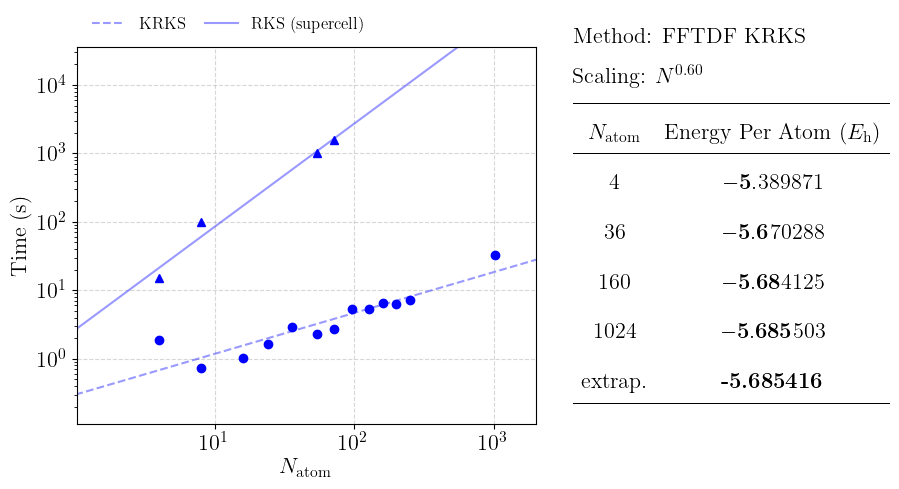

save figure to diamond-kpt-scaling-krks-fftdf-60.png


In [31]:
table = [
    (4, 0),
    # (16, 1),
    (36, 1),
    (160, 2),
    (1024, 3)
]

# for key in ["fftdf-60", "fftisdf-60-8", "gdf-2.0"]:
key = "fftdf-60"
methods = ["krks"]
fig, (ax1, ax2) = plot_and_make_table(methods, table, key, plot_scell=True)

time_krhf = 411.09
time_build_df =   0.00
time_krhf = 1656.13
time_build_df =   0.00
time_krhf = 782.84
time_build_df =   0.00
time_krhf =  95.84
time_build_df =   0.00
time_krhf = 240.92
time_build_df =   0.00
time_krhf = 273.31
time_build_df =   0.00
time_krhf =  50.99
time_build_df =   0.00
time_krhf =   6.58
time_build_df =   0.00
time_krhf =  21.21
time_build_df =   0.00
time_krhf =   1.87
time_build_df =   0.00
time_krhf = 1780.66
time_build_df =   0.00
time_krhf = 3661.32
time_build_df =   0.00
natm =    4, e =    -5.288410
natm =    8, e =    -5.414627
natm =   16, e =    -5.478611
natm =   24, e =    -5.499763
natm =   36, e =    -5.510738
natm =   54, e =    -5.511123
natm =   72, e =    -5.513956
natm =   96, e =    -5.515055
natm =  128, e =    -5.514334
natm =  160, e =    -5.514606
natm =  200, e =    -5.514553
natm =  250, e =    -5.514149
w =  [2.44140625e-07 1.25000000e-07 6.40000000e-08]
z =  [-5.51460558 -5.514553   -5.51414927]
index =  [-3, -2, -1]
a = -2245.3605, 

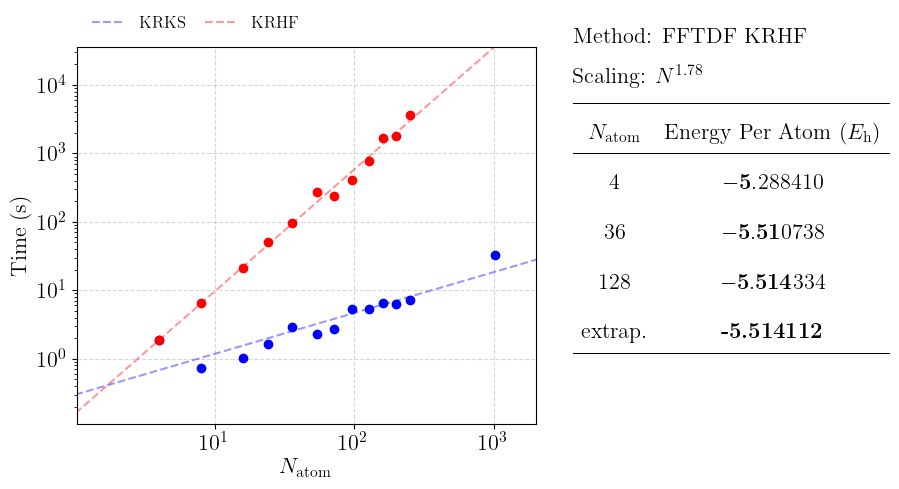

save figure to diamond-kpt-scaling-krhf-fftdf-60.png


(<Figure size 900x500 with 2 Axes>,
 (<Axes: xlabel='$N_{\\mathrm{atom}}$', ylabel='Time (s)'>, <Axes: >))

In [32]:
table = [
    (4, 0),
    (36, 2),
    (128, 3),
    # (250, 4),
]

# for key in ["fftdf-60", "fftisdf-60-8", "gdf-2.0"]:
key = "fftdf-60"
methods = ["krks", "krhf"]
plot_and_make_table(methods, table, key)

time_krhf = 411.09
time_build_df =   0.00
time_krhf = 1656.13
time_build_df =   0.00
time_krhf = 782.84
time_build_df =   0.00
time_krhf =  95.84
time_build_df =   0.00
time_krhf = 240.92
time_build_df =   0.00
time_krhf = 273.31
time_build_df =   0.00
time_krhf =  50.99
time_build_df =   0.00
time_krhf =   6.58
time_build_df =   0.00
time_krhf =  21.21
time_build_df =   0.00
time_krhf =   1.87
time_build_df =   0.00
time_krhf = 1780.66
time_build_df =   0.00
time_krhf = 3661.32
time_build_df =   0.00
natm =    4, e =    -5.397264
natm =    8, e =    -5.529147
natm =   16, e =    -5.595986
natm =   24, e =    -5.622711
natm =   36, e =    -5.636890
natm =   54, e =    -5.638588
natm =   72, e =    -5.643869
natm =   96, e =    -5.646365
natm =  128, e =    -5.646122
natm =  160, e =    -5.647396
natm =  200, e =    -5.647938
natm =  250, e =    -5.647757
w =  [2.44140625e-07 1.25000000e-07 6.40000000e-08]
z =  [-5.64739612 -5.64793765 -5.64775657]
index =  [-3, -2, -1]
a = 2350.8957, b

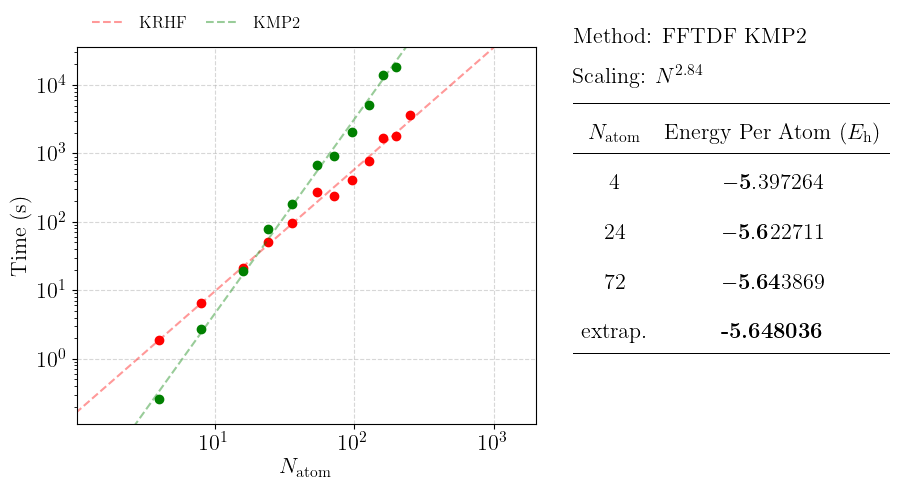

save figure to diamond-kpt-scaling-kmp2-fftdf-60.png


(<Figure size 900x500 with 2 Axes>,
 (<Axes: xlabel='$N_{\\mathrm{atom}}$', ylabel='Time (s)'>, <Axes: >))

In [33]:
table = [
    (4, 0),
    (24, 1),
    (72, 2),
]

# for key in ["fftdf-60", "fftisdf-60-8", "gdf-2.0"]:
key = "fftdf-60"
methods = ["krhf", "kmp2"]
plot_and_make_table(methods, table, key)

time_krhf = 411.09
time_build_df =   0.00
time_krhf = 1656.13
time_build_df =   0.00
time_krhf = 782.84
time_build_df =   0.00
time_krhf =  95.84
time_build_df =   0.00
time_krhf = 240.92
time_build_df =   0.00
time_krhf = 273.31
time_build_df =   0.00
time_krhf =  50.99
time_build_df =   0.00
time_krhf =   6.58
time_build_df =   0.00
time_krhf =  21.21
time_build_df =   0.00
time_krhf =   1.87
time_build_df =   0.00
time_krhf = 1780.66
time_build_df =   0.00
time_krhf = 3661.32
time_build_df =   0.00
natm =    4, e =    -5.411121
natm =    8, e =    -5.537831
natm =   16, e =    -5.602244
natm =   24, e =    -5.625781
natm =   36, e =    -5.638159
natm =   54, e =    -5.639218
natm =   72, e =    -5.643192
w =  [2.14334705e-05 6.35065793e-06 2.67918381e-06]
z =  [-5.63815945 -5.63921848 -5.64319211]
index =  [-3, -2, -1]
a = 210.8108, b =  -5.6423


/var/folders/sm/7t_ndz1j5n5dlj8m6tnm2h480000gn/T/ipykernel_61643/1386881489.py:63: RuntimeWarning: overflow encountered in power
  ax.semilogy(xx, base ** (a * xx + b), color=colors[method], linestyle='dashed', alpha=0.4, label=method.upper())
/Users/yangjunjie/anaconda3/lib/python3.12/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


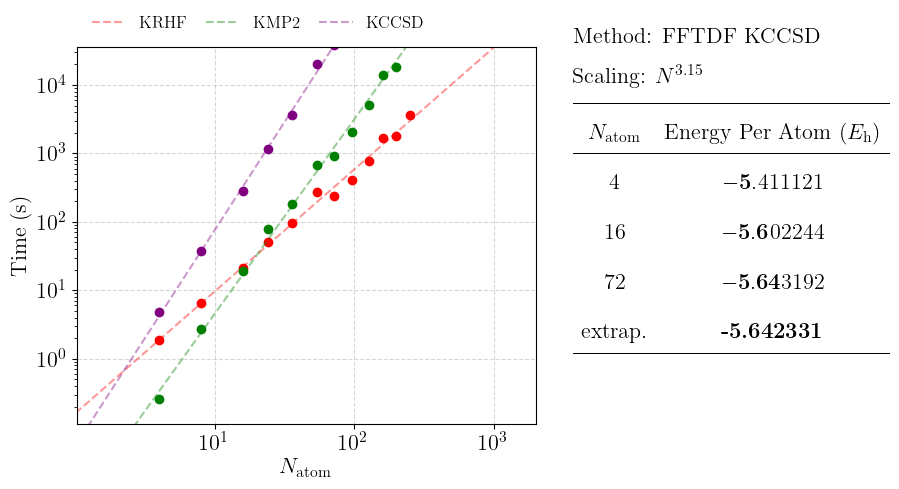

save figure to diamond-kpt-scaling-kccsd-fftdf-60.png


(<Figure size 900x500 with 2 Axes>,
 (<Axes: xlabel='$N_{\\mathrm{atom}}$', ylabel='Time (s)'>, <Axes: >))

In [34]:
table = [
    (4, 0),
    # (8, 1),
    (16, 1),
    # (24, 3),
    (72, 2),
]

# for key in ["fftdf-60", "fftisdf-60-8", "gdf-2.0"]:
key = "fftdf-60"
methods = ["krhf", "kmp2", "kccsd"]
plot_and_make_table(methods, table, key)

time_krhf =  14.01
time_build_df =  11.47
time_krhf =  67.20
time_build_df =  47.15
time_krhf =  22.10
time_build_df =  18.11
time_krhf =  37.55
time_build_df =  28.59
time_krhf =  12.88
time_build_df =   9.95
time_krhf =  60.45
time_build_df =  45.56
time_krhf =  33.49
time_build_df =  24.54
time_krhf =   6.21
time_build_df =   5.18
time_krhf =   9.50
time_build_df =   7.86
time_krhf =   9.84
time_build_df =   8.19
time_krhf =  23.80
time_build_df =  17.87
time_krhf =  98.48
time_build_df =  71.21
time_krhf =   7.10
time_build_df =   6.19
time_krhf =   5.09
time_build_df =   4.62
time_krhf =   4.73
time_build_df =   4.15
time_krhf =   3.17
time_build_df =   2.82
time_krhf =  83.53
time_build_df =  61.28
time_krhf =  26.67
time_build_df =  19.65
time_krhf =  23.02
time_build_df =  17.27
natm =    4, e =    -5.288514
natm =    8, e =    -5.414676
natm =   16, e =    -5.478652
natm =   24, e =    -5.499939
natm =   36, e =    -5.510837
natm =   54, e =    -5.511250
natm =   72, e =    -5

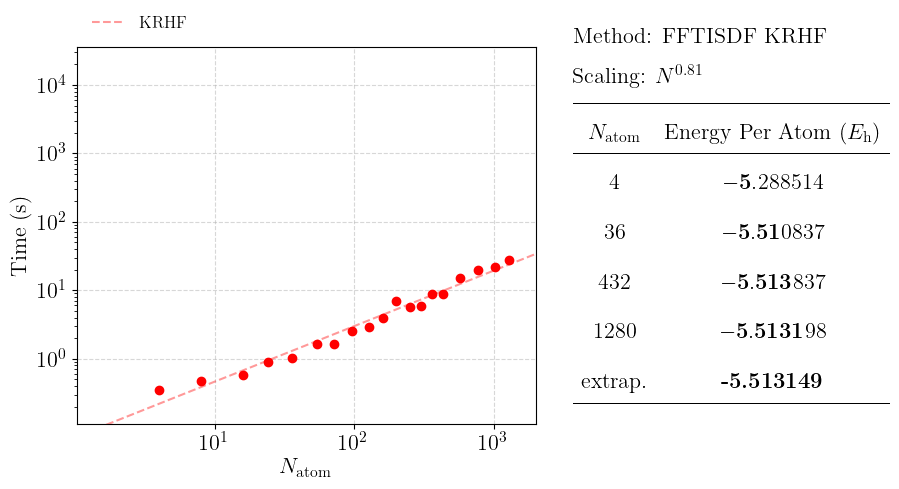

save figure to diamond-kpt-scaling-krhf-fftisdf-60-8.png


(<Figure size 900x500 with 2 Axes>,
 (<Axes: xlabel='$N_{\\mathrm{atom}}$', ylabel='Time (s)'>, <Axes: >))

In [35]:
table = [
    (4, 0),
    (36, 2),
    (432, 3),
    (1280, 4),
]

# for key in ["fftdf-60", "fftisdf-60-8", "gdf-2.0"]:
key = "fftisdf-60-8"
methods = ["krhf"]
plot_and_make_table(methods, table, key)

time_krhf =  14.01
time_build_df =  11.47
time_krhf =  67.20
time_build_df =  47.15
time_krhf =  22.10
time_build_df =  18.11
time_krhf =  37.55
time_build_df =  28.59
time_krhf =  12.88
time_build_df =   9.95
time_krhf =  60.45
time_build_df =  45.56
time_krhf =  33.49
time_build_df =  24.54
time_krhf =   6.21
time_build_df =   5.18
time_krhf =   9.50
time_build_df =   7.86
time_krhf =   9.84
time_build_df =   8.19
time_krhf =  23.80
time_build_df =  17.87
time_krhf =  98.48
time_build_df =  71.21
time_krhf =   7.10
time_build_df =   6.19
time_krhf =   5.09
time_build_df =   4.62
time_krhf =   4.73
time_build_df =   4.15
time_krhf =   3.17
time_build_df =   2.82
time_krhf =  83.53
time_build_df =  61.28
time_krhf =  26.67
time_build_df =  19.65
time_krhf =  23.02
time_build_df =  17.27
natm =    4, e =    -5.397354
natm =    8, e =    -5.529340
natm =   16, e =    -5.596222
natm =   24, e =    -5.622999
natm =   36, e =    -5.637216
natm =   54, e =    -5.638897
natm =   72, e =    -5

/Users/yangjunjie/anaconda3/lib/python3.12/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


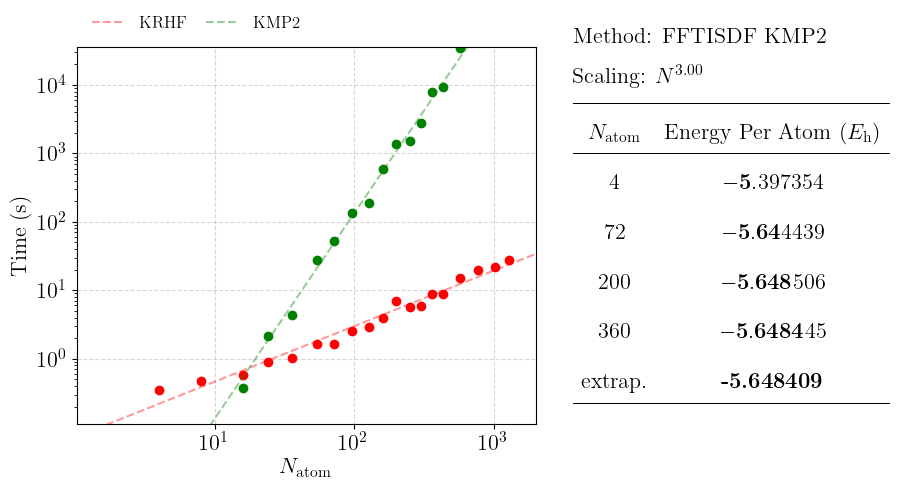

save figure to diamond-kpt-scaling-kmp2-fftisdf-60-8.png


(<Figure size 900x500 with 2 Axes>,
 (<Axes: xlabel='$N_{\\mathrm{atom}}$', ylabel='Time (s)'>, <Axes: >))

In [36]:
table = [
    (4, 0),
    (72, 2),
    (200, 3),
    (360, 4),
]

# for key in ["fftdf-60", "fftisdf-60-8", "gdf-2.0"]:
key = "fftisdf-60-8"
methods = ["krhf", "kmp2"]
plot_and_make_table(methods, table, key)

time_krhf =  14.01
time_build_df =  11.47
time_krhf =  67.20
time_build_df =  47.15
time_krhf =  22.10
time_build_df =  18.11
time_krhf =  37.55
time_build_df =  28.59
time_krhf =  12.88
time_build_df =   9.95
time_krhf =  60.45
time_build_df =  45.56
time_krhf =  33.49
time_build_df =  24.54
time_krhf =   6.21
time_build_df =   5.18
time_krhf =   9.50
time_build_df =   7.86
time_krhf =   9.84
time_build_df =   8.19
time_krhf =  23.80
time_build_df =  17.87
time_krhf =  98.48
time_build_df =  71.21
time_krhf =   7.10
time_build_df =   6.19
time_krhf =   5.09
time_build_df =   4.62
time_krhf =   4.73
time_build_df =   4.15
time_krhf =   3.17
time_build_df =   2.82
time_krhf =  83.53
time_build_df =  61.28
time_krhf =  26.67
time_build_df =  19.65
time_krhf =  23.02
time_build_df =  17.27
natm =    4, e =    -5.411219
natm =    8, e =    -5.538009
natm =   16, e =    -5.602465
natm =   24, e =    -5.626051
natm =   36, e =    -5.638452
natm =   54, e =    -5.639513
natm =   72, e =    -5

/var/folders/sm/7t_ndz1j5n5dlj8m6tnm2h480000gn/T/ipykernel_61643/1386881489.py:63: RuntimeWarning: overflow encountered in power
  ax.semilogy(xx, base ** (a * xx + b), color=colors[method], linestyle='dashed', alpha=0.4, label=method.upper())
/Users/yangjunjie/anaconda3/lib/python3.12/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


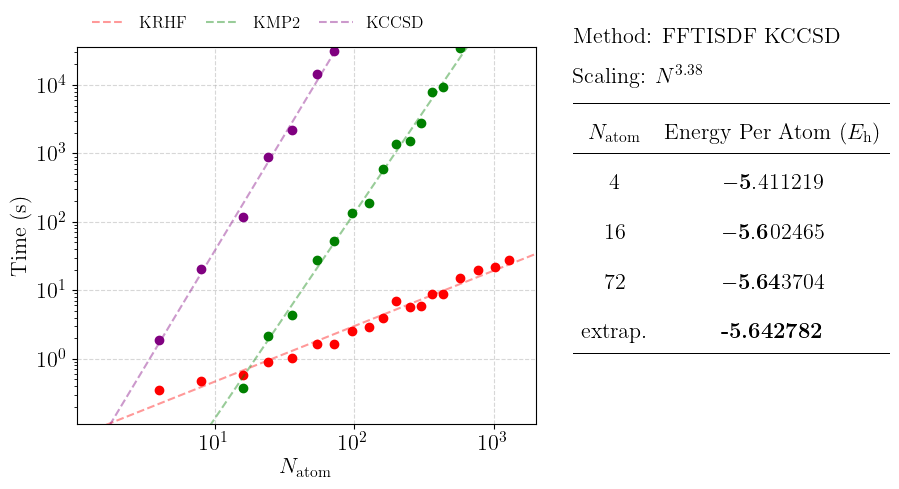

save figure to diamond-kpt-scaling-kccsd-fftisdf-60-8.png


(<Figure size 900x500 with 2 Axes>,
 (<Axes: xlabel='$N_{\\mathrm{atom}}$', ylabel='Time (s)'>, <Axes: >))

In [37]:
table = [
    (4, 0),
    (16, 1),
    (72, 2),
    # (432, 4),
]

# for key in ["fftdf-60", "fftisdf-60-8", "gdf-2.0"]:
key = "fftisdf-60-8"
methods = ["krhf", "kmp2", "kccsd"]
plot_and_make_table(methods, table, key)